In [17]:
import numpy as np
import os

import comet_ml #must be before torch

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer, required

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CometLogger

from typing import Any, Callable, Dict, Optional, Sequence, Tuple, Union, List

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from collections import namedtuple
from functools import partial

from helper import ReshapeTransform

from datetime import datetime

from mpl2latex import mpl2latex, latex_figsize

In [2]:
#Load (normalized) MNIST dataset, split into train/validation/test, reshape to 1D vectors.

#From: https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html
class MNISTDataModule(pl.LightningDataModule):
    
    def __init__(self,
                 data_dir : str = os.getcwd(),
                 train_batch_size : int = 16,
                 test_batch_size  : int = 1000):
        
        super().__init__()
        
        #---Store arguments---#
        self.data_dir = data_dir
        self.train_batch_size = train_batch_size
        self.test_batch_size  = test_batch_size
        
        #---Transforms---#
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.double()),
        ])
        
        self.dims = (1,28,28)
        
    def setup(self, stage : Optional[str] = None):
        if stage == 'fit' or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transforms)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [50000, 10000]) #Train/Validation split
        
        if stage == 'test' or stage is None:
            self.mnist_test  = MNIST(self.data_dir, train=False, transform=self.transforms)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.train_batch_size, pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.test_batch_size, pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.test_batch_size, pin_memory=True)


In [3]:
class Local(Optimizer):
    """
    A simple optimizer that changes weights according to `weights += learning_rate * delta_weights`,
    for a provided `delta_weights`, automatically retrieving the `learning_rate` from each layer metadata.
    
    Taken from: https://github.com/Joxis/pytorch-hebbian/blob/595ec79577c3816c61d39b0633f8dbf14d28b67a/pytorch_hebbian/optimizers/local.py#L15
    """
    
    def __init__(self, named_params, lr=required):
        self.param_names, params = zip(*named_params)
        
        if lr is not required and lr < 0.0: #?
            raise ValueError("Invalid learning rate: {}".format(lr))
    
        defaults = dict(lr=lr)
        super(Local, self).__init__(params, defaults)
    
    def local_step(self, delta_weights, layer_name, closure=None):
        """Performs a single local optimization step: weights += learning_rate * delta_weights.
        The needed learning_rate is automatically retrieved from the layer metadata."""
        
        loss = None
        if closure is not None:
            loss = closure()
            
        for group in self.param_groups:
            layer_index = self.param_names.index(layer_name + '.weight') #find index of layer
            weights = group['params'][layer_index]
            weights.data.add_(group['lr'] * delta_weights)
            #print("Add weights to ", layer_index)
        
        try:
            self._step_count += 1
        except AttributeError:
            pass
        
        return loss

In [4]:
class BioLearningRule():
    """
    Implements the bio-inspired Hebbian learning rule from [1]. 
    
    Adapted from https://github.com/Joxis/pytorch-hebbian/blob/master/pytorch_hebbian/learning_rules/krotov.py
    
    [1]: "Unsupervised learning by competing hidden units", D. Krotov, J. J. Hopfield, 2019, 
         https://www.pnas.org/content/116/16/7723
    """
    
    def __init__(self,
                 precision     : float = 1e-30,
                 delta         : float = 0.4,
                 lebesgue_p    : float = 2.0, 
                 ranking_param : int   = 2):
        """
        Parameters
        ----------
        precision : float
            Minimum value that is considered non-zero.
        delta : float
            Strength of anti-Hebbian learning (from eq. 9 in [1]). 
        lebesgue_p : float
            Parameter for Lebesgue measure, used for defining an inner product (from eq. 2 in [1]).
        ranking_param: int
            Rank of the current to which anti-hebbian learning is applied. Should be >= 2. This is the `k` from eq. 10 in [1].
        """
        
        #Store hyperparameters
        self.precision     = precision
        self.delta         = delta
        self.lebesgue_p    = lebesgue_p
        self.ranking_param = ranking_param
        
        print(self)
        
    def __str__(self):
        """Return string representation of the object"""
        
        return "Krotov-Hopfield Hebbian learning rule (delta={:.2f}, lebesgue_p={:.2f}, ranking_param={})".format(self.delta, self.lebesgue_p, self.ranking_param)
    
    def __repr__(self):
        """Return string representation of the object"""
        
        return str(self)
    
    def __call__(self,
                 inputs  : torch.Tensor,
                 weights : torch.Tensor,
                 isconv  : bool = False) -> torch.tensor:
        """
        Compute the change of `weights` given by the Krotov learning rule (eq. 3 from [1], with R=1)
        for a given batch of `inputs`. See "A fast implementation" section in [1].
        
        The formula is:
        ```delta_weights = g(currents) @ inputs - normalization_mtx (*) weights
        currents = (sgn(weights) (*) abs(weights) ** lebesgue_p) @ inputs.T```
        
        where `normalization_mtx` is a matrix of the same shape of `weights`, with all columns equal to:
        ```\sum_{batches} [g(currents) (*) currents]```
        
        The symbol `@` denotes matrix multiplication, while `(*)` is element-wise multiplication (Hadamard product).
        Finally, the function `g` (eq. 10 in [1]) returns:
        ```g(currents[i,j]) = 1      if currents[i,j] is the highest in the j-th column (sample),
                              -Delta if currets[i,j] is the k-th highest value in the j-th column (sample),
                               0     otherwise```
        
         
        Parameters
        ----------
        inputs : torch.Tensor of shape (batch_size, input_size)
            Batch of inputs
        weights : torch.Tensor of shape (output_size, input_size)
            Model's weights
        isconv : bool
            True if the layer is nn.Conv2d, False if it is nn.Linear
        
        Returns
        -------
        delta_weights : torch.Tensor of shape (output_size, input_size)
            Change of weights given by the fast implementation of Krotov learning rule. The tensor is normalized
            so that its maximum is equal to 1.
        """
                
        batch_size = inputs.shape[0]
        
        if not isconv: #Linear logic
            #---Currents---#
            inputs = torch.t(inputs) #Shape is (batch_size, input_size) -> (input_size, batch_size)
            currents = torch.matmul(torch.sign(weights) * torch.abs(weights) ** (self.lebesgue_p - 1), inputs) #Shape is (output_size, batch_size)

            #---Activations---#
            _, ranking_indices = currents.topk(self.ranking_param, dim=0) #Shape is (self.ranking_param, batch_size)
            #Indices of the top k currents produced by each input sample

            post_activation_currents = torch.zeros_like(currents) #Shape is (output_size, batch_size)
            #Computes g(currents)
            #Note that all activations are 0, except the largest current (activation of 1) and the k-th largest (activation of -delta)        

            batch_indices = torch.arange(batch_size, device=post_activation_currents.device) 
            post_activation_currents[ranking_indices[0], batch_indices] = 1.0
            post_activation_currents[ranking_indices[self.ranking_param-1], batch_indices] = -self.delta

            #---Compute change of weights---#
            delta_weights = torch.matmul(post_activation_currents, torch.t(inputs)) #Overlap between post_activation_currents and inputs
            second_term   = torch.sum(torch.mul(post_activation_currents, currents), dim=1) #Overlap between currents and post_activation_currents
            #Results are summed over batches, resulting in a shape of (output_size,)        

            delta_weights = delta_weights - second_term.unsqueeze(1) * weights

        else: #Convolutional logic
            batch_size = inputs.shape[0]

            currents = F.conv2d(input=inputs, weight=(torch.sign(weights) * torch.abs(weights) ** self.lebesgue_p)) 
            #(batch_size, out_channel, out_height, out_width)


            original_shape = currents.shape
            _, ranking_indices = currents.view(batch_size, -1).topk(self.ranking_param, dim=1)
            ranking_indices = torch.t(ranking_indices)

            batch_indices = torch.arange(batch_size, device=inputs.device)

            post_activation_currents = torch.zeros((batch_size, np.prod(original_shape[1:])), device=inputs.device, dtype=inputs.dtype)
            post_activation_currents[batch_indices, ranking_indices[0]] = 1.0
            post_activation_currents[batch_indices, ranking_indices[self.ranking_param -1 ]] = -self.delta
            post_activation_currents = post_activation_currents.reshape(original_shape)


            delta_weights = F.conv2d(inputs.permute(1, 0, 2, 3), post_activation_currents.permute(1, 0, 2, 3)).permute(1, 0, 2, 3)

            term = torch.sum(post_activation_currents * currents, dim = 0)
            
            ones = torch.ones(inputs.shape[1:], device=inputs.device, dtype=inputs.dtype) # / np.prod(inputs.shape[2:])

            term2 = F.conv2d(ones.unsqueeze(1), term.unsqueeze(1)).permute(1, 0, 2, 3)

            delta_weights = delta_weights - term2 * weights
            
        #---Normalize---#
        nc = torch.max(torch.abs(delta_weights)) 
        if nc < self.precision:
            nc = self.precision

        return delta_weights / nc #Maximum (absolute) change of weight is set to +1. 
    

In [5]:
class CNN(nn.Module):
    
    def __init__(self, 
                 output_dim : int = 10,
                 n : int = 1,
                 beta : float = .1):
        """Builds the neural network architecture presented in [1].

        Parameters
        ----------
        output_dim : int
            Output dimensionality (number of classes)
        n : int
            Exponent of activation function for the first hidden layer (n = 1 for ReLU). See eq. 1 in [1].
        beta : float
            Parameter for the activation function in the top layer (akin to an "inverse temperature"). See eq. 1 in [1].         
        
        [1]: "Unsupervised learning by competing hidden units", D. Krotov, J. Hopfield, 2019
        """
        
        super(CNN, self).__init__()
        
        #Store parameters
        self.n = n
        self.beta = beta
        
        #Define layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=10, bias=False)
        self.max_pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 5, kernel_size=8, bias=False)
        self.fc1 = nn.Linear(2,3)
        
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        """
        Compute the output of the network for the input `x`.
        
        Parameters
        ----------
        x : torch.Tensor of shape (batch_size, self.input_dim)
            Batch of input values
        
        Returns
        -------
        out : torch.Tensor of shape (batch_size, self.output_dim)
            Batch of output values
        """
        
        x = F.relu(self.conv1(x))
        x = max_pool(x)
        x = F.relu(self.conv2(x))
        
        return x

In [6]:
class UnsupervisedPhase(pl.LightningModule):
    """
    Perform unsupervised learning of the first layers of a sequential network according to some local learning rule.
    """
    
    def __init__(self,
                 model               : torch.nn.Sequential,
                 update_weights_rule : Callable,
                 supervised_from     : int = -1,
                 freeze_layers       : List[str] = None,
                 n_epochs            : int = 100
                ):
        """
        Parameters
        ----------
        model : torch.nn.Sequential
            Model to be trained. Must be a sequence of Linear layers (+ some activations).
        update_weights_rule : function
            Function that computes the change of weights
        supervised_from : int
            Train all layers that appear *before* `supervised_from`. By default, all layers except the very last one are trained.
        freeze_layers : list of strings
            Names of layers to be excluded from training.
        n_epochs : int
            Number of epochs for the full training (needed to set the learning rate)
        """
        
        super().__init__()
        
        #---Store arguments---#
        self.model           = model
        self.supervised_from = supervised_from
        self.freeze_layers   = freeze_layers
        self.update_weights_rule = update_weights_rule
        self.n_epochs = n_epochs
        
        if self.freeze_layers is None:
            self.freeze_layers = []
            
        self.layers = [] #Save all layers that need to be trained
        Layer = namedtuple('Layer', ['idx', 'name', 'layer']) #simple object to store layer metadata
        
        for idx, (name, layer) in enumerate(list(model.named_children())[:self.supervised_from]):
            if (type(layer) == torch.nn.Linear or type(layer) == torch.nn.Conv2d) and name not in self.freeze_layers:
                self.layers.append(Layer(idx, name, layer))
                
                layer.weight.data.normal_(mean=0.0, std=1.0) #and initialize weights with normal distribution
        
        print("Layers selected for unsupervised local (bio)learning:")
        print("{} layer(s): ".format(len(self.layers)), [lyr.name for lyr in self.layers])
        
        #Register hooks in trainable layers so that input/output can be stored (which is needed for Hebbian learning)
        self._hooks = {} 
        self._inputs = {}
        self._outputs = {}
        
        for layer in self.layers:
            self._hooks[layer.name] = layer.layer.register_forward_hook(
                partial(self._store_data_hook, layer_name=layer.name)
            )
            
        self.automatic_optimization = False #Disable automatic gradient optimizations 
        #(since we are using a local optimizer, which does not need any gradient)
        
    def forward(self, x : torch.Tensor):
        """Compute model output"""
        
        return self.model.forward(x)
    
    def _store_data_hook(self, _, inp, out, layer_name):
        """Hook for storing input/outputs of trainable layers"""

        self._inputs[layer_name] = inp[0]
        self._outputs[layer_name] = out
    
        
    def training_step(self, batch : torch.Tensor, batch_idx : int):
        """
        Single iteration of the training cycle.
        """
        
        opt = self.optimizers() #Retrieve the optimizer
        
        with torch.no_grad(): #No gradient is needed
            x, y = batch

            #---Forward step---#
            layers = list(self.model.children())
            for layer in layers[:self.supervised_from]:  #-1
                x = layer(x)
            
            #---Unsupervised learning---#
            for layer_idx, layer_name, layer in self.layers:
                inputs = self._inputs[layer_name]
                    
                weights = layer.weight
                
                isconv = (type(layer) == torch.nn.Conv2d)
                
                #Compute change of weights
                delta_weights = self.update_weights_rule(inputs, weights, isconv)
                delta_weights = delta_weights.view(*layer.weight.size()) #Flatten
                
                #Update weights
                opt.local_step(delta_weights, layer_name=layer_name)
                
        return x, y
        
    def configure_optimizers(self):
        """Define optimizer and learning rate schedule."""
        
        start_lr = .015
        optimizer = Local(named_params = self.model.named_parameters(), lr=start_lr)
        lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (self.n_epochs - epoch) / self.n_epochs,
                                                         verbose=True)
        
        return [optimizer], [lr_scheduler]

In [18]:
import matplotlib.pyplot as plt

def plot_weights(t, fig=None):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 6
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    
    if fig is None:
        fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg, cmap='bwr', interpolation=None)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [16]:
trainer = Trainer(gpus=[0], max_epochs=10)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [9]:
mnist = MNISTDataModule(train_batch_size=16)
update_weights_rule = BioLearningRule(delta=.4, lebesgue_p=2, ranking_param=2)
net = CNN(10).double()
print(net)

full_system = UnsupervisedPhase(model=net, update_weights_rule=update_weights_rule, n_epochs=trainer.max_epochs)

Krotov-Hopfield Hebbian learning rule (delta=0.40, lebesgue_p=3.00, ranking_param=2)
CNN(
  (conv1): Conv2d(1, 16, kernel_size=(10, 10), stride=(1, 1), bias=False)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 5, kernel_size=(8, 8), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=2, out_features=3, bias=True)
)
Layers selected for unsupervised local (bio)learning:
2 layer(s):  ['conv1', 'conv2']


In [12]:
trainer.fit(full_system, mnist) #Run training!

C:\Users\franc\Anaconda3\envs\torch\lib\site-packages\pytorch_lightning\utilities\distributed.py:50: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)


Adjusting learning rate of group 0 to 1.5000e-02.



  | Name  | Type | Params
-------------------------------
0 | model | CNN  | 6.7 K 
-------------------------------
6.7 K     Trainable params
0         Non-trainable params
6.7 K     Total params
0.027     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

C:\Users\franc\Anaconda3\envs\torch\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 5.0000e-03.
Adjusting learning rate of group 0 to 0.0000e+00.


1

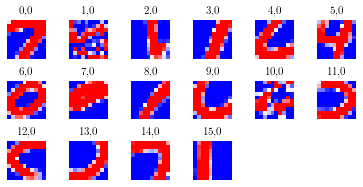

In [22]:
with mpl2latex(True):
    fig = plt.figure(figsize=latex_figsize(wf=1.2, hf=.5, columnwidth=318.67))
    fig.patch.set_facecolor('none')
    
    weights = next(full_system.layers[0].layer.parameters()).detach().cpu()
    plot_weights(weights[:, :, :, :], fig=fig)
    
    plt.show()
    
    fig.savefig("Plots/CNN_weights.pdf", transparent=True, bbox_inches='tight')

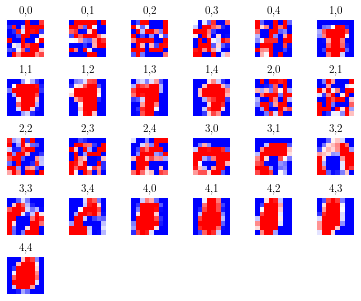

In [26]:
with mpl2latex(True):
    fig = plt.figure(figsize=latex_figsize(wf=1.2, hf=.8, columnwidth=318.67))
    fig.patch.set_facecolor('none')
    
    weights = next(full_system.layers[1].layer.parameters()).detach().cpu()
    plot_weights(weights[:5, :5, :, :], fig=fig)
    
    plt.show()
    
    fig.savefig("Plots/CNN_weights_2.pdf", transparent=True, bbox_inches='tight')